In [1]:
# Auto-reload modules when they change.
%load_ext autoreload
%autoreload 2

In [ ]:
# Modifying the path so we can import from src directory.
import sys
import os
sys.path.append(os.path.abspath('..'))

import ast
import copy
import pickle
import time

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from src.example_graphs import simple_undirected_graph, simple_directed_graph
from src.UndirectedGraph import UndirectedGraph
from src.DirectedGraph import DirectedGraph
from src.DataLoader import DataLoader, PandasDataLoader
from src.GraphCreator import GraphCreator

from src.io_helpers import pickle_obj, load_pickled_obj
from src.networkx_helpers import combine_graphs

In [4]:
ROOT_DIRECTORY = os.path.split(os.getcwd())[0]
DATA_DIRECTORY = os.path.join(ROOT_DIRECTORY, 'data')
PICKLED_DATA_DIRECTORY = os.path.join(ROOT_DIRECTORY, 'data_pickle')

# Simple Graphs

In [14]:
# Create simple undirected graph.
g = simple_undirected_graph()
g_class = UndirectedGraph(g)
print(g_class.graph)

{'A': ['B'], 'B': ['A', 'C', 'D'], 'C': ['B', 'D'], 'D': ['B', 'C'], 'E': []}


In [15]:
# Create simple directed graph.
g_directed = simple_directed_graph()
g_directed_class = DirectedGraph(g_directed)

# Test DirectedGraph class functionality.
g_directed_class.add_node('F', ('A', 'C'))
g_directed_class.add_edge('C', 'F')
g_directed_class.remove_edge('F', 'C')

In [16]:
print(g_directed_class.graph)

{'A': ['B'], 'B': ['C', 'D'], 'C': ['D', 'F'], 'D': [], 'E': [], 'F': ['A']}


# Load Reddit Hyperlink Data into Custom Graph Class

Here's an example of how you could read the data and pickle it.

```python
# Read in some lines of Reddit Hyperlink data.
start_time = time.time()
data_loader = DataLoader(num_lines=1000, cols_to_load=['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT'])
lines = data_loader.load()

graph_creator = GraphCreator()
reddit_body_hyperlink_graph = graph_creator.create_graph(lines)
graph_creator.pickle_graph(reddit_body_hyperlink_graph, "data_pickle/reddit_body_1000.pickle")
end_time = time.time()
print("Time to load and pickle 1000 rows: {}".format(end_time - start_time))

# Create full pickle file of the non-multigraph Reddit Hyperlink body data.
start_time = time.time()
data_loader = DataLoader(full_file=True, cols_to_load=['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT'])
lines = data_loader.load()

graph_creator = GraphCreator()
reddit_body_hyperlink_graph = graph_creator.create_graph(lines)
graph_creator.pickle_graph(reddit_body_hyperlink_graph, "data_pickle/reddit_body_full_non_multigraph.pickle")
end_time = time.time()
print("Time to load and pickle full file (non-multigraph): {}".format(end_time - start_time))
```

# Analyzing the Data in Pandas
Before analyzing the graph data via the graph structure, let's just look at some basics in pandas.

```python
def value_count_overlap(counts1, counts2, n, return_list=False):
    overlap = set(counts1.head(n).index).intersection(set(counts2.head(n).index))
    if return_list:
        return len(overlap), overlap
    else:
        return len(overlap)


pandas_loader = 
df_body = pd.read_csv("data/soc-redditHyperlinks-body.tsv", delimiter='\t')
df_title = pd.read_csv("data/soc-redditHyperlinks-title.tsv", delimiter='\t')

# Look at df_body
print(df_body.info())
print(df_body.describe())

# Look at df_body
print(df_title.info())
print(df_title.describe())

# Get post ids from each file.
title_post_ids = set(df_title['POST_ID'])
body_post_ids = set(df_body['POST_ID'])

# Are there any post ids in common? (Nope. We get 0 here.)
inter = title_post_ids.intersection(body_post_ids)
print(len(inter))

# Let's look at the top subreddits by where they're posted.
body_source_counts = df_body["SOURCE_SUBREDDIT"].value_counts()
title_source_counts = df_title["SOURCE_SUBREDDIT"].value_counts()

# Are there commonalities between the two datasets for SOURCE?
print(set(body_source_counts.head(10).index).intersection(set(title_source_counts.head(10).index)))
print(set(body_source_counts.head(20).index).intersection(set(title_source_counts.head(20).index)))
print(set(body_source_counts.head(50).index).intersection(set(title_source_counts.head(50).index)))

# Let's look at the top subreddits by who they're referencing / posting about.
body_target_counts = df_body["TARGET_SUBREDDIT"].value_counts()
title_target_counts = df_title["TARGET_SUBREDDIT"].value_counts()

# Let's look at the top 10 for each file.
print(body_target_counts.head(10))
print(title_target_counts.head(10))

# Are there commonalities between the two datasets for TARGET?
print(set(body_target_counts.head(10).index).intersection(set(title_target_counts.head(10).index)))
print(set(body_target_counts.head(20).index).intersection(set(title_target_counts.head(20).index)))
print(set(body_target_counts.head(50).index).intersection(set(title_target_counts.head(50).index)))

# Now let's look at what the top SOURCE and TARGET are for the combined df.
df_concat = pd.concat([df_body, df_title])
concat_source_counts = df_concat["SOURCE_SUBREDDIT"].value_counts()
concat_target_counts = df_concat["TARGET_SUBREDDIT"].value_counts()

# Let's look at the top 10 for SOURCE and TARGET for the concat df.
print(concat_source_counts.head(10))
print(concat_target_counts.head(10))

# Now let's look at the counts of the overlap with the body and title datasets
print(value_count_overlap(concat_source_counts, body_source_counts, 10))
print(value_count_overlap(concat_source_counts, title_source_counts, 10))
print(value_count_overlap(concat_target_counts, body_target_counts, 10))
print(value_count_overlap(concat_target_counts, title_target_counts, 10))
```

# Using the PandasDataLoader class to load the combined dataset

```python
from src.DataLoader import PandasDataLoader

p_loader = PandasDataLoader(
    os.path.join(DATA_DIRECTORY, "soc-redditHyperlinks-body.tsv"),
    os.path.join(DATA_DIRECTORY, "soc-redditHyperlinks-title.tsv")
)

df = p_loader.load()
```

# Look at basic stats in pandas

In [7]:
from src.DataLoader import PandasDataLoader

p_loader = PandasDataLoader(
    os.path.join(DATA_DIRECTORY, "soc-redditHyperlinks-body.tsv"),
    os.path.join(DATA_DIRECTORY, "soc-redditHyperlinks-title.tsv")
)

df = p_loader.load()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 858488 entries, 0 to 571926
Data columns (total 6 columns):
SOURCE_SUBREDDIT    858488 non-null object
TARGET_SUBREDDIT    858488 non-null object
POST_ID             858488 non-null object
TIMESTAMP           858488 non-null object
LINK_SENTIMENT      858488 non-null int64
PROPERTIES          858488 non-null object
dtypes: int64(1), object(5)
memory usage: 45.8+ MB


In [10]:
df.describe()

,LINK_SENTIMENT
count,858488.000000
mean,0.808477
std,0.588528
min,-1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


## Link Sentiment

Text(0, 0.5, 'count of hyperlinks')

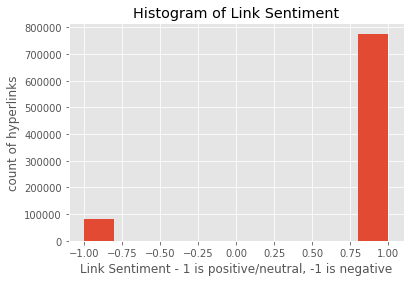

In [41]:
bins = plt.hist(df['LINK_SENTIMENT'])
plt.title("Histogram of Link Sentiment")
plt.xlabel("Link Sentiment - 1 is positive/neutral, -1 is negative")
plt.ylabel("count of hyperlinks")

In [29]:
print(bins)

(array([ 82210.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0., 776278.]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]), <a list of 10 Patch objects>)


In [34]:
df_sample = df.iloc[:5]

In [35]:
df_sample

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


### Number of subreddits total

In [60]:
len(set(df['SOURCE_SUBREDDIT']).union(set(df['TARGET_SUBREDDIT'])))

67180

## Turning text properties into columns that can be summarized

In [ ]:
df_properties = PandasDataLoader.generate_properties_df(df)

In [66]:
text_property_columns = ['Number of characters','Number of characters without counting white space','Fraction of alphabetical characters','Fraction of digits','Fraction of uppercase characters','Fraction of white spaces','Fraction of special characters, such as comma, exclamation mark, etc.','Number of words','Number of unique works','Number of long words (at least 6 characters)','Average word length','Number of unique stopwords','Fraction of stopwords','Number of sentences','Number of long sentences (at least 10 words)','Average number of characters per sentence','Average number of words per sentence','Automated readability index','Positive sentiment calculated by VADER','Negative sentiment calculated by VADER','Compound sentiment calculated by VADER','LIWC_Funct','LIWC_Pronoun','LIWC_Ppron','LIWC_I','LIWC_We','LIWC_You','LIWC_SheHe','LIWC_They','LIWC_Ipron','LIWC_Article','LIWC_Verbs','LIWC_AuxVb','LIWC_Past','LIWC_Present','LIWC_Future','LIWC_Adverbs','LIWC_Prep','LIWC_Conj','LIWC_Negate','LIWC_Quant','LIWC_Numbers','LIWC_Swear','LIWC_Social','LIWC_Family','LIWC_Friends','LIWC_Humans','LIWC_Affect','LIWC_Posemo','LIWC_Negemo','LIWC_Anx','LIWC_Anger','LIWC_Sad','LIWC_CogMech','LIWC_Insight','LIWC_Cause','LIWC_Discrep','LIWC_Tentat','LIWC_Certain','LIWC_Inhib','LIWC_Incl','LIWC_Excl','LIWC_Percept','LIWC_See','LIWC_Hear','LIWC_Feel','LIWC_Bio','LIWC_Body','LIWC_Health','LIWC_Sexual','LIWC_Ingest','LIWC_Relativ','LIWC_Motion','LIWC_Space','LIWC_Time','LIWC_Work','LIWC_Achiev','LIWC_Leisure','LIWC_Home','LIWC_Money','LIWC_Relig','LIWC_Death','LIWC_Assent','LIWC_Dissent','LIWC_Nonflu','LIWC_Filler']

In [72]:
df_combined.head()['PROPERTIES']

0    345.0,298.0,0.75652173913,0.0173913043478,0.08...
1    101.0,98.0,0.742574257426,0.019801980198,0.049...
2    85.0,85.0,0.752941176471,0.0235294117647,0.082...
3    1124.0,949.0,0.772241992883,0.0017793594306,0....
4    715.0,622.0,0.777622377622,0.00699300699301,0....
Name: PROPERTIES, dtype: object

In [75]:
text_property_series = df.apply(lambda row: ast.literal_eval(row['PROPERTIES']), axis=1).values

In [76]:
text_properties_list = text_property_series.tolist()

In [77]:
df_properties = pd.DataFrame(text_properties_list, columns=text_property_columns)

In [78]:
df_properties.shape

(858488, 86)

In [79]:
df_properties.head()

,Number of characters,Number of characters without counting white space,Fraction of alphabetical characters,Fraction of digits,Fraction of uppercase characters,Fraction of white spaces,"Fraction of special characters, such as comma, exclamation mark, etc.",Number of words,Number of unique works,Number of long words (at least 6 characters),...,LIWC_Achiev,LIWC_Leisure,LIWC_Home,LIWC_Money,LIWC_Relig,LIWC_Death,LIWC_Assent,LIWC_Dissent,LIWC_Nonflu,LIWC_Filler
0,345.0,298.0,0.756522,0.017391,0.086957,0.150725,0.075362,57.0,53.0,10.0,...,0.068966,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,101.0,98.0,0.742574,0.019802,0.049505,0.059406,0.178218,14.0,14.0,2.0,...,0.000000,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,85.0,85.0,0.752941,0.023529,0.082353,0.011765,0.211765,10.0,10.0,2.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,1124.0,949.0,0.772242,0.001779,0.057829,0.179715,0.046263,191.0,125.0,34.0,...,0.031250,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.005208
4,715.0,622.0,0.777622,0.006993,0.025175,0.145455,0.069930,119.0,92.0,22.0,...,0.016667,0.025000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.008333
